##  Working with Relative Humidity

In [1]:
#importing the libraries to be used

############################################
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from cartopy import feature as cf
import seaborn as sns
import calendar
import warnings
############################################

# from mpl_toolkits.basemap import Basemap
#from metpy.cbook import get_test_data
# from matplotlib import cm
# import matplotlib.ticker as mticker


In [2]:
######################################
#loading the dataset5
era5_data = xr.open_dataset('era5_t2m_d2m.nc')
era5_data

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 408)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2023-12-01
Data variables:
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-03 19:05:28 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [3]:
# defining the necessary parameters  
beta = 17.625
gamma = 243.04

#converting kelvins to degree celcius
Dew_Temp = era5_data['d2m'] - 273.15
Temp = era5_data['t2m'] - 273.15

In [4]:
#obtaining the relative humidity variable
Rel_Humidity = 100 * (np.exp((beta * Dew_Temp) / (gamma + Dew_Temp)) / 
                      np.exp((beta * Temp) / (gamma + Temp)))

In [5]:
# Create an xarray.DataArray for Relative Humidity
Rel_Hum = xr.DataArray(
    data = Rel_Humidity,
    coords=Dew_Temp.coords,
    dims=Dew_Temp.dims,
    name='rh'  # Naming the variable 'rh'
)

#  add it to the era5_data dataset to keep everything together
if 'rh' not in era5_data:
    era5_data['rh'] = Rel_Hum

In [6]:
era5_data

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 408)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2023-12-01
Data variables:
    d2m        (time, latitude, longitude) float32 253.6 253.6 ... 241.7 241.7
    t2m        (time, latitude, longitude) float32 256.1 256.1 ... 245.1 245.1
    rh         (time, latitude, longitude) float32 80.78 80.78 ... 73.24 73.24
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-03 19:05:28 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Descriptive Statistics

### Global

In [8]:

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Select the data
rh_data = era5_data['rh'].sel(time=slice('1991', '2023')).values

# Compute the mean
rh_mean = np.mean(rh_data)

# Compute the standard deviation
rh_std = np.std(rh_data)

# Compute the maximum
rh_max = np.max(rh_data)

# Compute the minimum
rh_min = np.min(rh_data)

# Compute the percentiles
rh_25 = np.percentile(rh_data, 25)
rh_50 = np.percentile(rh_data, 50)
rh_75 = np.percentile(rh_data, 75)

# Print or use the results
print("Mean:", rh_mean)
print("Standard Deviation:", rh_std)
print("Maximum:", rh_max)
print("Minimum:", rh_min)
print("25th Percentile:", rh_25)
print("50th Percentile:", rh_50)
print("75th Percentile:", rh_75)


Mean: 74.26996
Standard Deviation: 12.97116
Maximum: 99.23569
Minimum: 3.2364984
25th Percentile: 70.97489929199219
50th Percentile: 77.34104919433594
75th Percentile: 81.71229553222656


### West Africa

In [9]:

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Select the data
west_rh = era5_data['rh'].sel(longitude=slice(-20, 16), latitude=slice(18, -1)).sel(time=slice('1991', '2023'))

# Convert to NumPy array
west_rh_data = west_rh.values

# Compute the mean
west_rh_mean = np.mean(west_rh_data)

# Compute the standard deviation
west_rh_std = np.std(west_rh_data)

# Compute the maximum
west_rh_max = np.max(west_rh_data)

# Compute the minimum
west_rh_min = np.min(west_rh_data)

# Compute the percentiles
west_rh_25 = np.percentile(west_rh_data, 25)
west_rh_50 = np.percentile(west_rh_data, 50)
west_rh_75 = np.percentile(west_rh_data, 75)

# Print or use the results
print("Mean:", west_rh_mean)
print("Standard Deviation:", west_rh_std)
print("Maximum:", west_rh_max)
print("Minimum:", west_rh_min)
print("25th Percentile:", west_rh_25)
print("50th Percentile:", west_rh_50)
print("75th Percentile:", west_rh_75)


Mean: 58.19453
Standard Deviation: 27.72437
Maximum: 95.845055
Minimum: 6.5547967
25th Percentile: 27.346285820007324
50th Percentile: 73.08640670776367
75th Percentile: 82.55733489990234


## Heatmaps

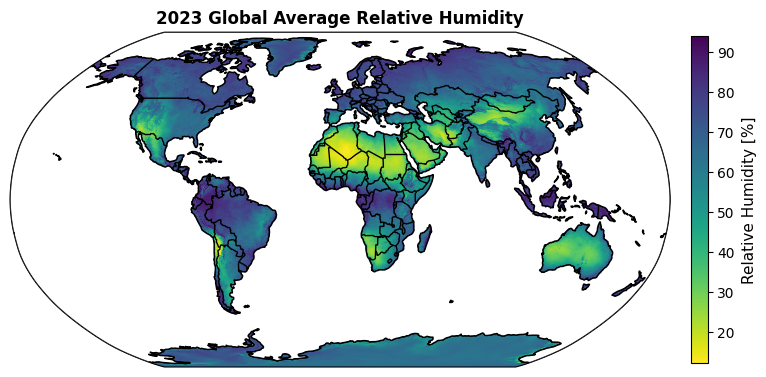

In [7]:
# Extract rh data for the year 2023
rh_2023 = era5_data['rh'].sel(time='2023')

# Calculate the average rh for the year 2023
rh_2023_avg = rh_2023.mean(dim='time')

def Global_plot(ERA5_dataset, title):
    fig, ax = plt.subplots(figsize=(9, 4.5), 
                           subplot_kw=dict(projection=ccrs.Robinson(central_longitude = 0)))

    im = ax.pcolormesh(ERA5_dataset.longitude, 
                       ERA5_dataset.latitude, 
                       ERA5_dataset,
                       transform=ccrs.PlateCarree(), 
                       cmap='viridis_r', 
                       shading='auto')
# ax.add_feature(cf.LAND, edgecolor='black', zorder=0)
    ax.add_feature(cf.BORDERS)
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.OCEAN, edgecolor='black', zorder=100, facecolor = 'white')



    ax.set_title(title, fontweight='bold')
    
    
    
    # Adding colorbar
    cb = plt.colorbar(im, fraction=0.0235, pad=0.03)
    cb.set_label(label = 'Relative Humidity [%]', fontsize=11, rotation=90, labelpad = 5)

    # display the title
    plt.show()

# Call the function with the rh data for 2023 and a custom title
Global_plot(rh_2023_avg, '2023 Global Average Relative Humidity')


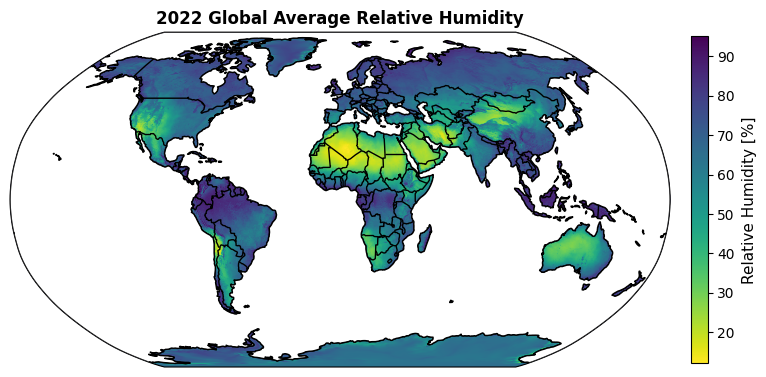

In [8]:
# Extract rh data for the year 2023
rh_2023 = era5_data['rh'].sel(time='2022')

# Calculate the average rh for the year 2023
rh_2023_avg = rh_2023.mean(dim='time')

def Global_plot(ERA5_dataset, title):
    fig, ax = plt.subplots(figsize=(9, 4.5), 
                           subplot_kw=dict(projection=ccrs.Robinson(central_longitude = 0)))

    im = ax.pcolormesh(ERA5_dataset.longitude, 
                       ERA5_dataset.latitude, 
                       ERA5_dataset,
                       transform=ccrs.PlateCarree(), 
                      cmap='viridis_r', 
                       shading='auto')
# ax.add_feature(cf.LAND, edgecolor='black', zorder=0)
    ax.add_feature(cf.BORDERS)
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.OCEAN, edgecolor='black', zorder=100, facecolor = 'white')



    ax.set_title(title, fontweight='bold')
    
    
    
    # Adding colorbar
    cb = plt.colorbar(im, fraction=0.0235, pad=0.03)
    cb.set_label(label = 'Relative Humidity [%]', fontsize=11, rotation=90, labelpad = 5)

    # display the plot
    plt.show()

# Call the function with the SST data for 2023 and a custom title
Global_plot(rh_2023_avg, '2022 Global Average Relative Humidity')


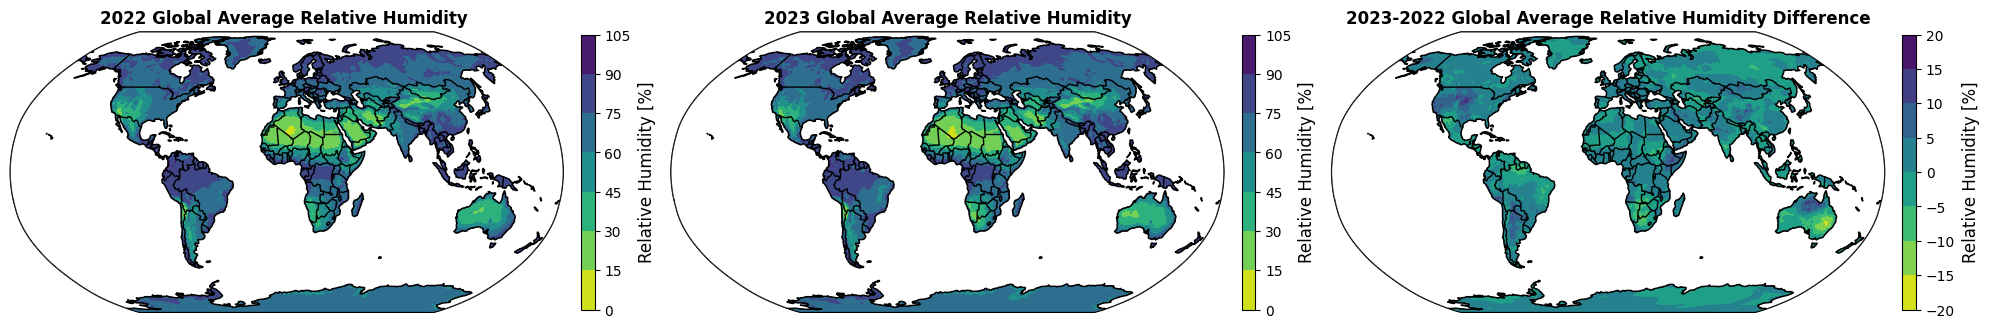

In [9]:
# Extract drought data for the year 2023
rh_2022 = era5_data['rh'].sel(time='2022')

rh_2023 = era5_data['rh'].sel(time='2023')

# # Calculate the average sm for the year 2023
rh_2022_avg = rh_2022.mean(dim='time')

rh_2023_avg = rh_2023.mean(dim='time')

# Calculate difference
rh_diff = rh_2023_avg - rh_2022_avg


# Function to create a plot
def global_plot(ax, data, title):
    cs = ax.contourf(data.longitude, 
                     data.latitude, 
                     data,
                     transform=ccrs.PlateCarree(), 
                     cmap='viridis_r')

    ax.add_feature(cf.BORDERS)
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.OCEAN, edgecolor='black', zorder=100, facecolor='white')

#     ax.set_extent([-20, 16, -1, 20], crs=ccrs.PlateCarree())
    ax.set_title(title, fontweight='bold')

    cb = plt.colorbar(cs, ax=ax, fraction=0.0235, pad=0.03)
    cb.set_label(label = 'Relative Humidity [%]', fontsize=12, rotation=90, labelpad = 5)

# Create a 1 by 3 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), subplot_kw={'projection': ccrs.Robinson()})

# Plot for 2022
global_plot(axs[0], rh_2022_avg, '2022 Global Average Relative Humidity ')

# Plot for 2023
global_plot(axs[1], rh_2023_avg, '2023 Global Average Relative Humidity')

# Plot for difference between 2023 and 2022
global_plot(axs[2], rh_diff, '2023-2022 Global Average Relative Humidity Difference')

plt.tight_layout()
plt.show()


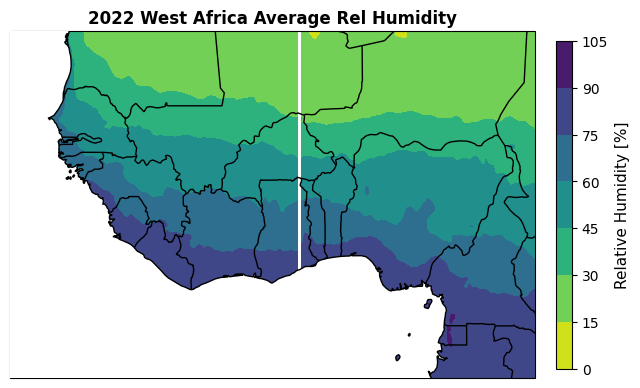

In [10]:
# Extract drought data for the year 2023
hum_rh = era5_data['rh'].sel(time='2022')

# # Calculate the average rh for the year 2023
hum_rh_avg = hum_rh.mean(dim='time')


def Global_plot(ERA5_dataset, title):
    fig, ax = plt.subplots(figsize=(9, 4.5), 
                           subplot_kw=dict(projection=ccrs.Robinson()))

    cs = ax.contourf(ERA5_dataset.longitude, 
                       ERA5_dataset.latitude, 
                       ERA5_dataset,
                       transform=ccrs.PlateCarree(), 
                       cmap='viridis_r')

    ax.add_feature(cf.BORDERS)
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.OCEAN, edgecolor='black', zorder=100, facecolor = 'white')
    
    ax.set_extent([-20, 16, -1, 20], crs=ccrs.PlateCarree())  # Set extent for West Africa

    
    # Adding colorbar
    cb = plt.colorbar(cs, fraction=0.0235, pad=0.03)
    cb.set_label(label = 'Relative Humidity [%]', fontsize=11, rotation=90, labelpad = 5)
    
    
    # Set the title passed as an argument
    ax.set_title(title, fontweight='bold')
    plt.show()

# Call the function with the rh data for 2023 and a custom title
Global_plot(hum_rh_avg, '2022 West Africa Average Rel Humidity')


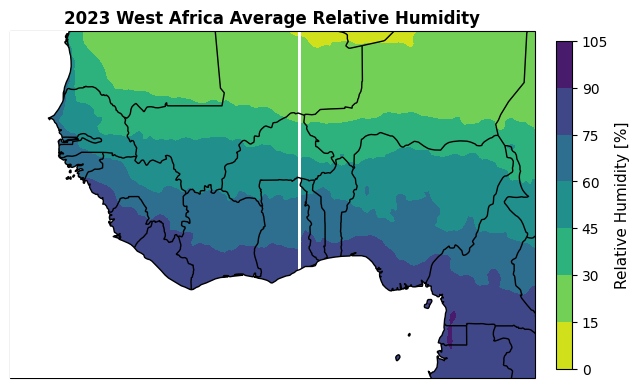

In [11]:
# Extract drought data for the year 2023
hum_rh = era5_data['rh'].sel(time='2023')

# # Calculate the average rh for the year 2023
hum_rh_avg = hum_rh.mean(dim='time')


def Global_plot(ERA5_dataset, title):
    fig, ax = plt.subplots(figsize=(9, 4.5), 
                           subplot_kw=dict(projection=ccrs.Robinson()))

    cs = ax.contourf(ERA5_dataset.longitude, 
                       ERA5_dataset.latitude, 
                       ERA5_dataset,
                       transform=ccrs.PlateCarree(), 
                       cmap='viridis_r')

    ax.add_feature(cf.BORDERS)
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.OCEAN, edgecolor='black', zorder=100, facecolor = 'white')
    
    ax.set_extent([-20, 16, -1, 20], crs=ccrs.PlateCarree())  # Set extent for West Africa

    
    # Adding colorbar
    cb = plt.colorbar(cs, fraction=0.0235, pad=0.03)
    cb.set_label(label = 'Relative Humidity [%]', fontsize=11, rotation=90, labelpad = 5)
    
    
    # Set the title passed as an argument
    ax.set_title(title, fontweight='bold')
    plt.show()

# Call the function with the rh data for 2023 and a custom title
Global_plot(hum_rh_avg, '2023 West Africa Average Relative Humidity')


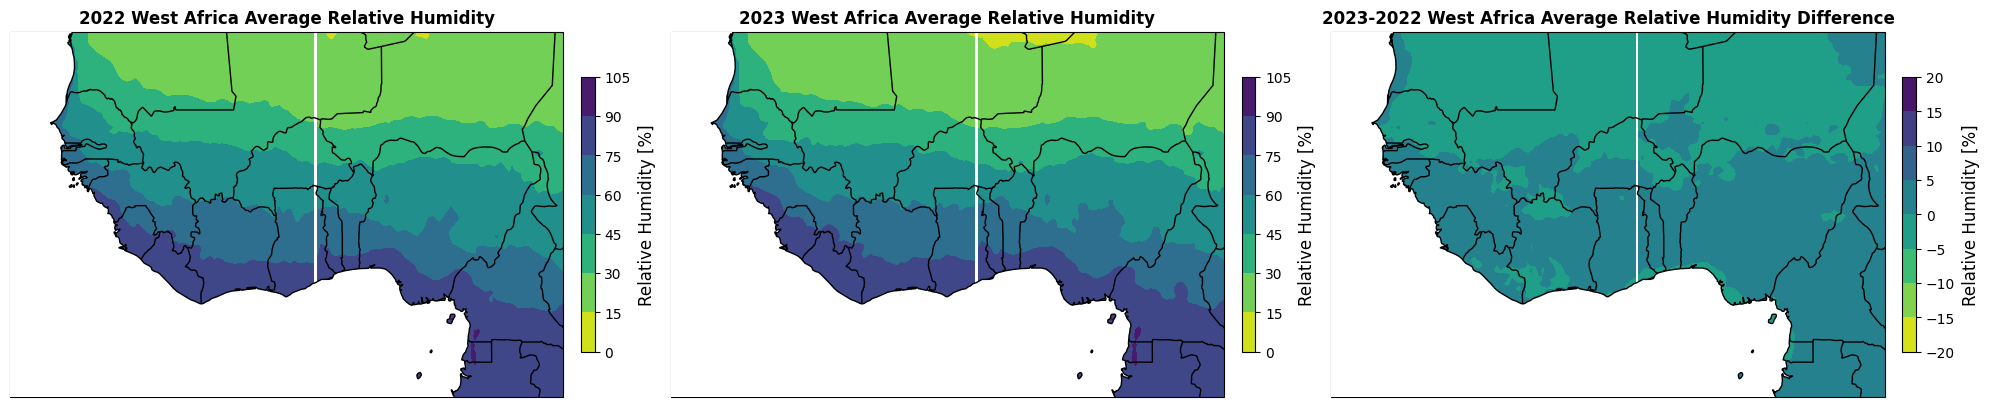

In [12]:
# Extract drought data for the year 2023
hum_rh_2022 = era5_data['rh'].sel(time='2022')

hum_rh_2023 = era5_data['rh'].sel(time='2023')

# # Calculate the average sm for the year 2023
hum_rh_2022_avg = hum_rh_2022.mean(dim='time')

hum_rh_2023_avg = hum_rh_2023.mean(dim='time')

# Calculate difference
hum_rh_diff = hum_rh_2023_avg - hum_rh_2022_avg


# Function to create a plot
def global_plot(ax, data, title):
    cs = ax.contourf(data.longitude, 
                     data.latitude, 
                     data,
                     transform=ccrs.PlateCarree(), 
                     cmap='viridis_r')

    ax.add_feature(cf.BORDERS)
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.OCEAN, edgecolor='black', zorder=100, facecolor='white')

    ax.set_extent([-20, 16, -1, 20], crs=ccrs.PlateCarree())
    ax.set_title(title, fontweight='bold')

    cb = plt.colorbar(cs, ax=ax, fraction=0.0235, pad=0.03)
    cb.set_label(label = 'Relative Humidity [%]', fontsize=12, rotation=90, labelpad = 5)

# Create a 1 by 3 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), subplot_kw={'projection': ccrs.Robinson()})

# Plot for 2022
global_plot(axs[0], hum_rh_2022_avg, '2022 West Africa Average Relative Humidity')

# Plot for 2023
global_plot(axs[1], hum_rh_2023_avg, '2023 West Africa Average Relative Humidity')

# Plot for difference between 2023 and 2022
global_plot(axs[2], hum_rh_diff, '2023-2022 West Africa Average Relative Humidity Difference')

plt.tight_layout()
plt.show()


### Monthly 2023 Global Relative Humidity Anomaly

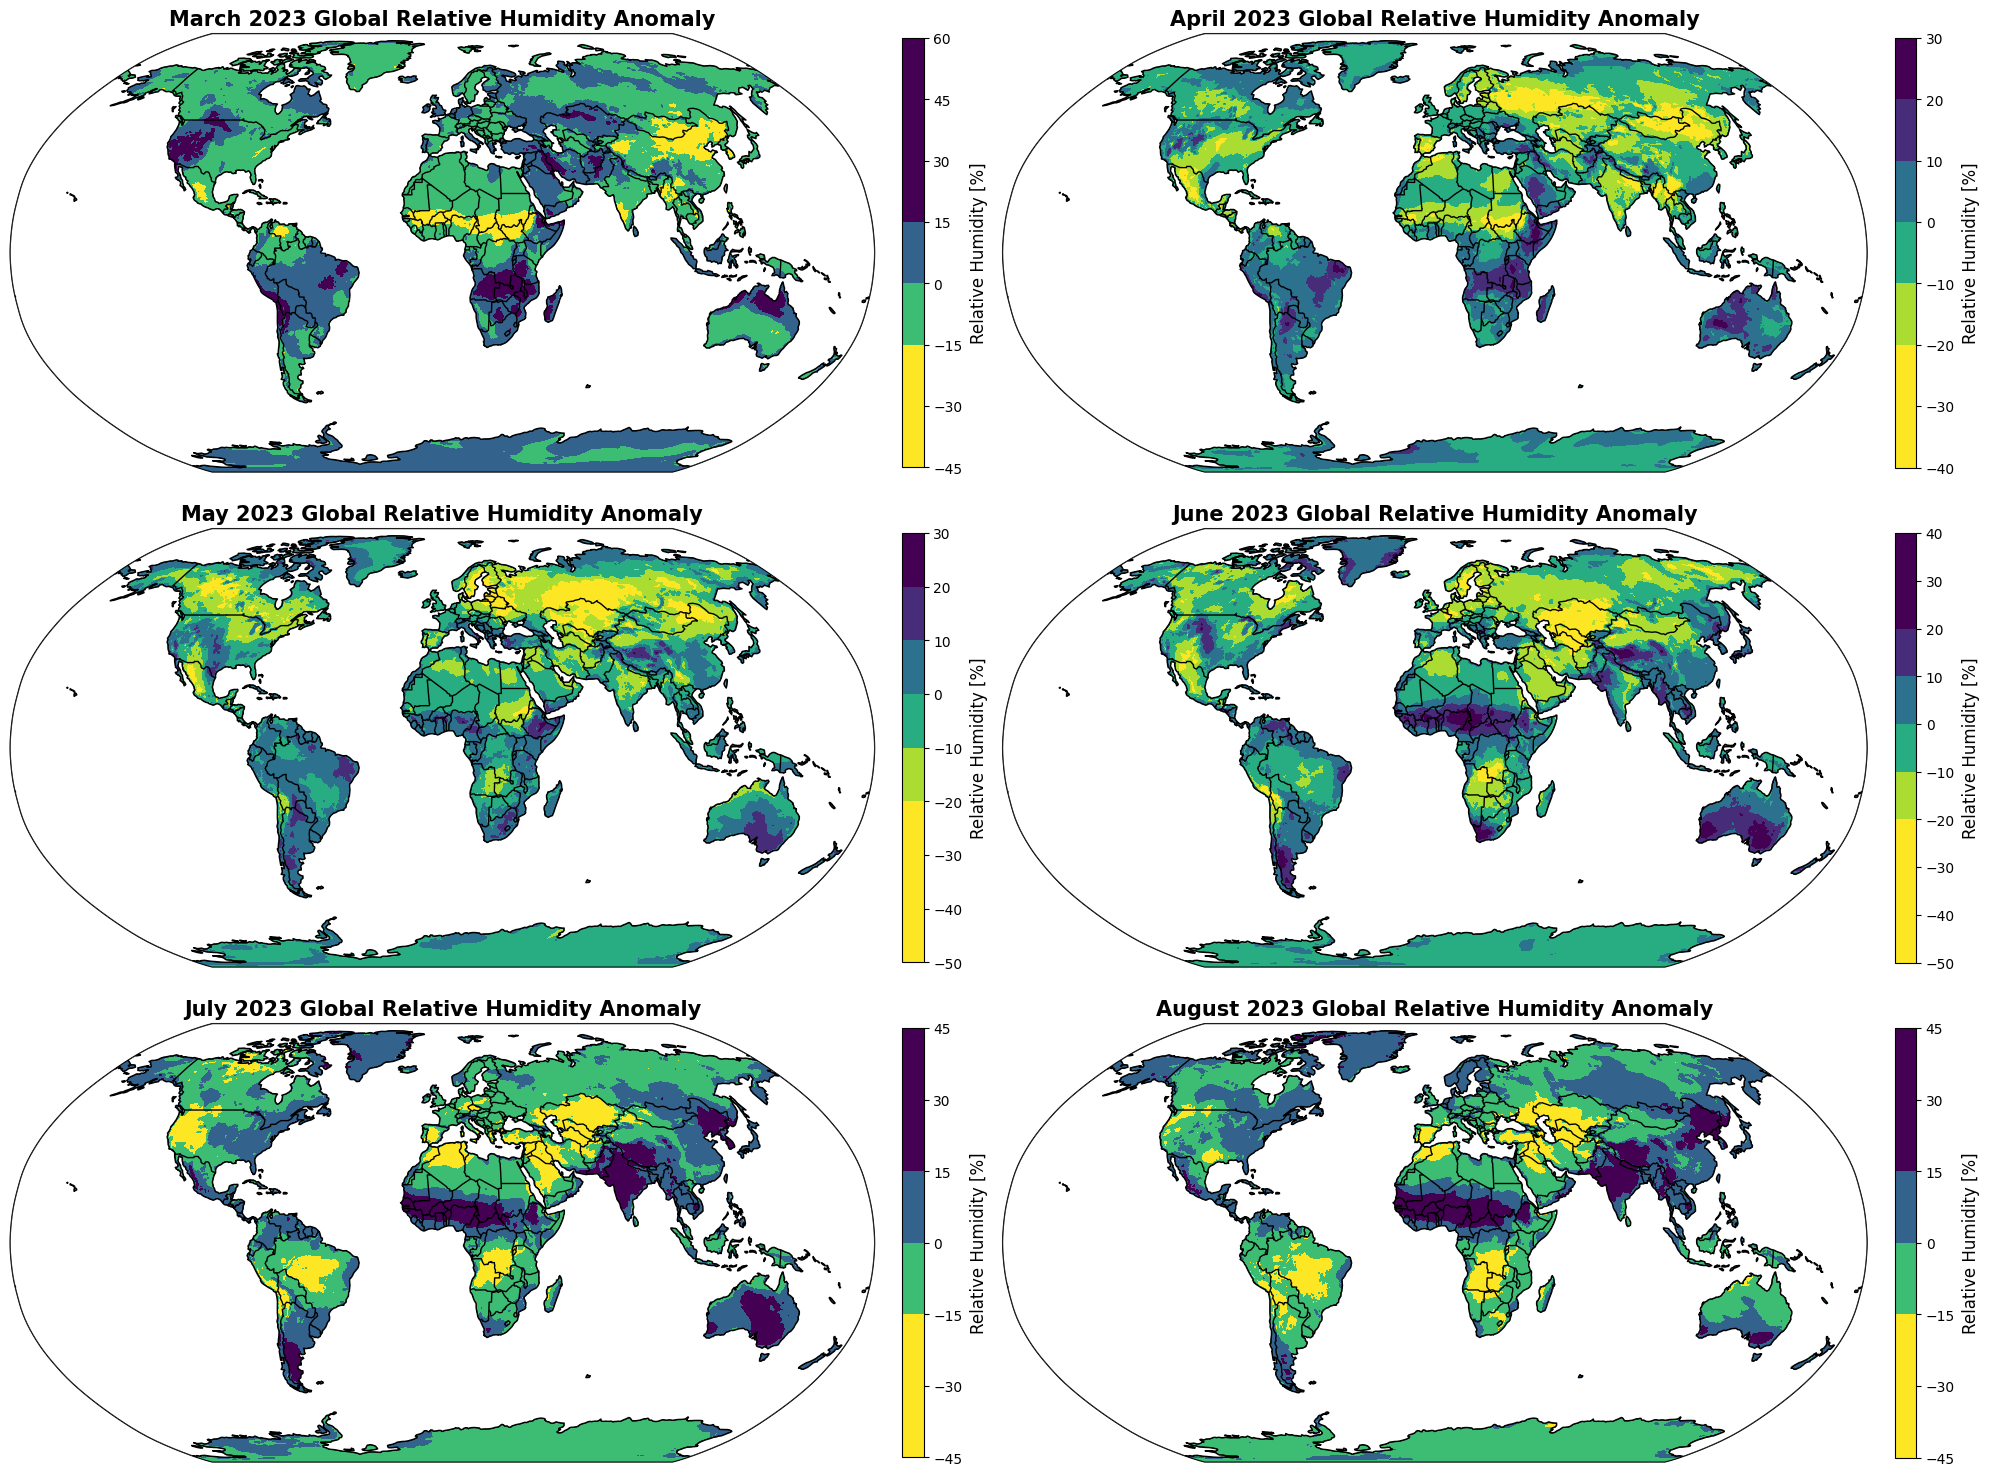

In [13]:
#define the function
def Global_plot(ERA5_dataset, title, ax):
    im = ax.contourf(ERA5_dataset.longitude, 
                       ERA5_dataset.latitude, 
                       ERA5_dataset,
                       transform=ccrs.PlateCarree(), 
                       vmin=-20, 
                       vmax= 20,
                       cmap='viridis_r')

   # ax.add_feature(cf.LAND, edgecolor='black', zorder=0)
    ax.add_feature(cf.BORDERS)
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.OCEAN, edgecolor='black', zorder=100, facecolor = 'white')
    
    
    cb = plt.colorbar(im, ax=ax, fraction=0.0235, pad=0.03)
    cb.set_label(label = 'Relative Humidity [%]', fontsize=12, rotation=90, labelpad = 5)

    ax.set_title(title, fontweight='bold', fontsize = '15')

# Create a 3 by 2 subplot layout
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15),
                        subplot_kw=dict(projection=ccrs.Robinson(central_longitude = 0)))

# List of months
months = ['March', 'April', 'May', 'June', 'July', 'August']

# Iterate through each month and plot
for i, month in enumerate(months):
    row = i // 2
    col = i % 2
    
    #difference between the years
    #select the specific years needed
    t2m_1991_2020 =  era5_data['rh'].sel(time=slice('1991', '2020')) #base period
    
    # Let's start with the current month in 2023
    current_month = '2023-{:02d}'.format(i + 3)
    t2m_month_2023 = era5_data['rh'].sel(time=current_month)
    
    # Calculate averages
    t2m_month_2023_avg = t2m_month_2023.mean(dim='time')
    t2m_1991_2020_avg = t2m_1991_2020.mean(dim='time')
    
    # Calculate the mean difference
    t2m_diff_avg = t2m_month_2023_avg - t2m_1991_2020_avg
    
    # Plot on the corresponding subplot
    Global_plot(t2m_diff_avg, f'{month} 2023 Global Relative Humidity Anomaly', axs[row, col])

plt.tight_layout()
plt.show()


### Monthly 2023 West Africa Relative Humidity Anomaly

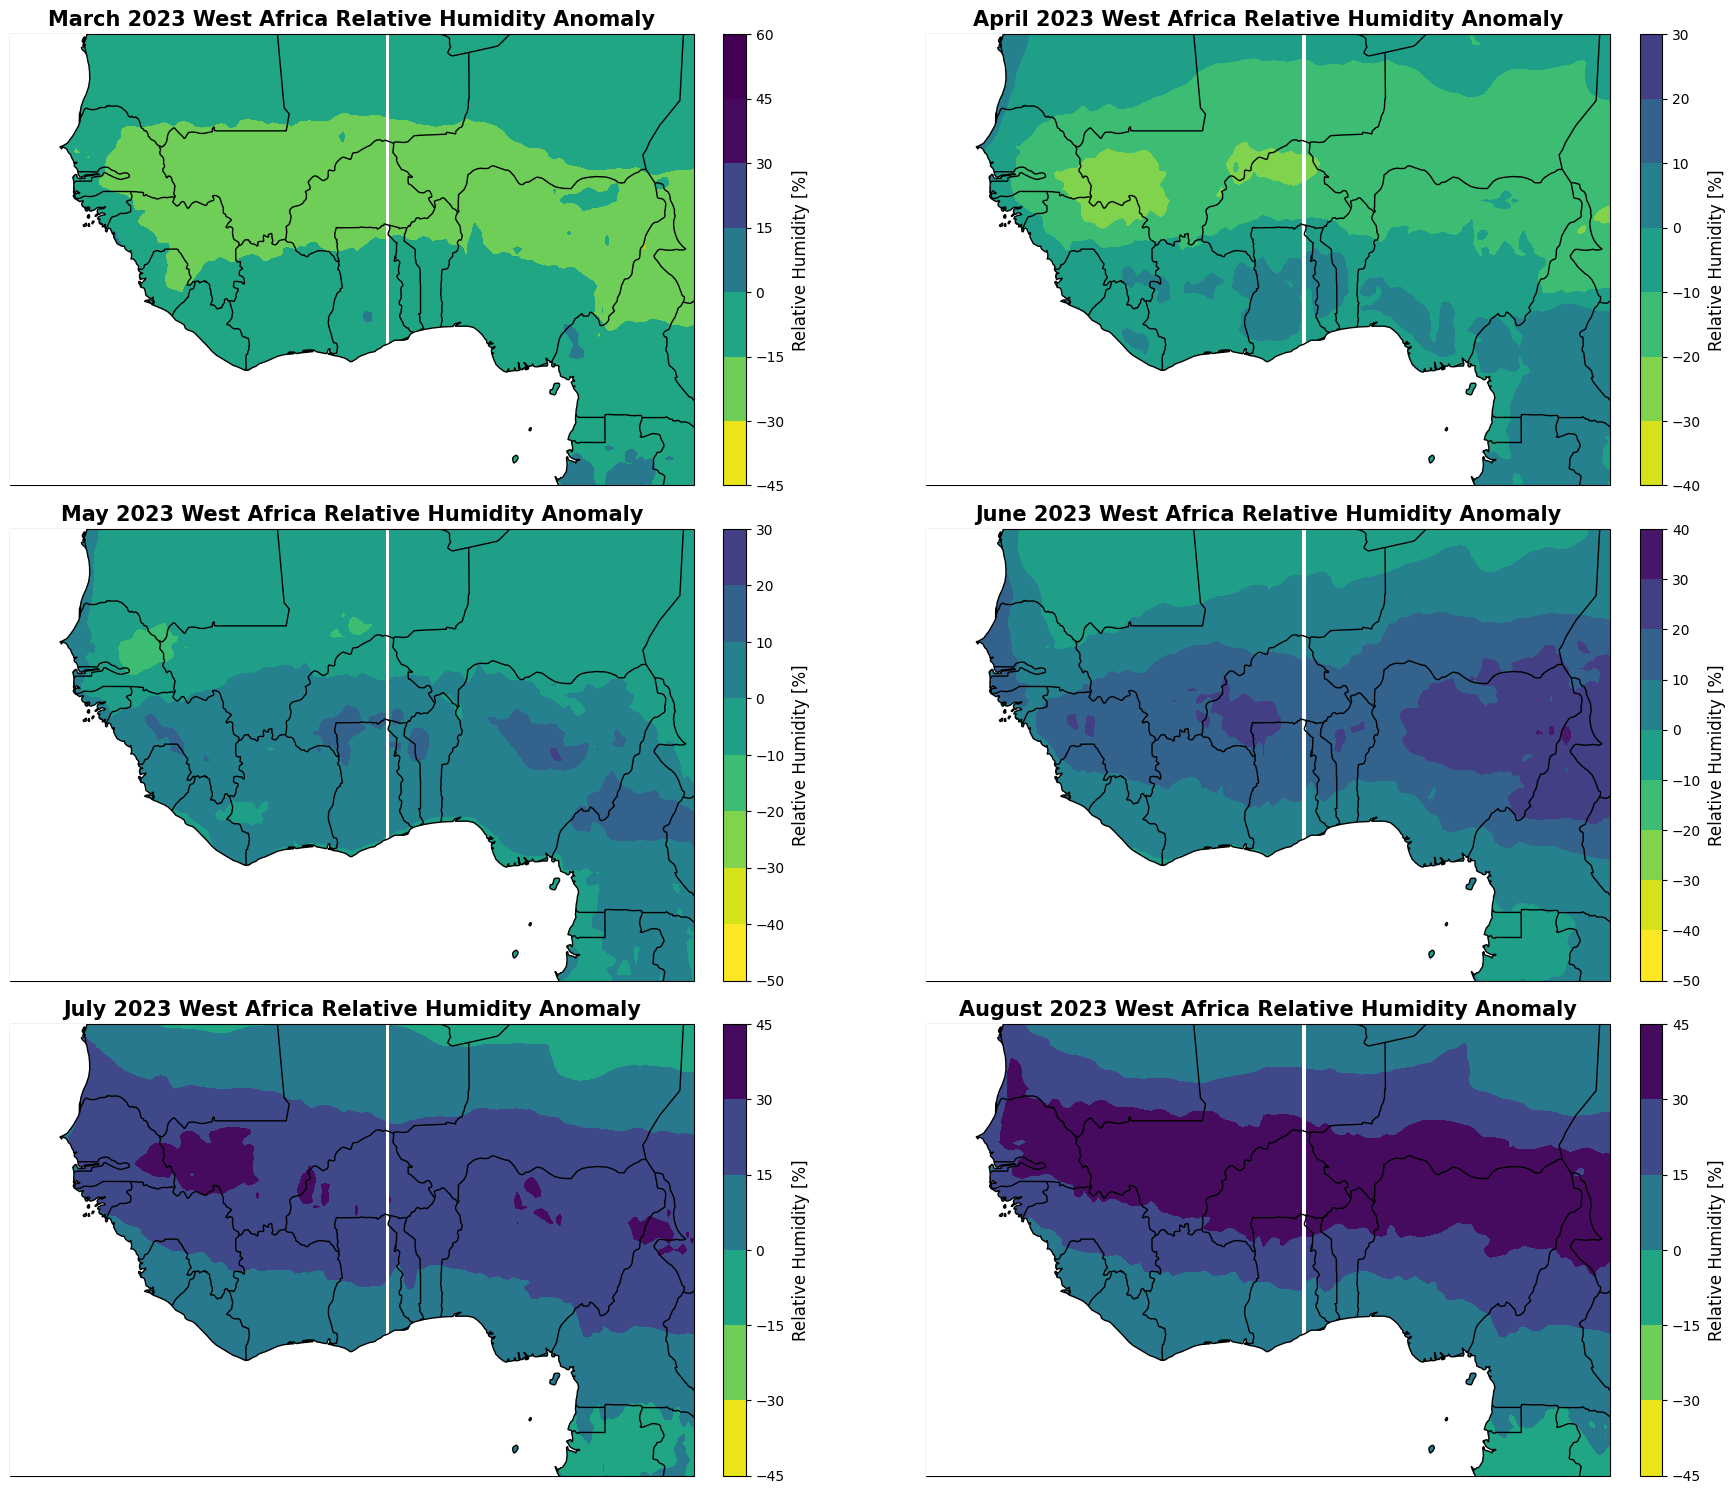

In [14]:
def Global_plot(ERA5_dataset, title, ax):
    im = ax.contourf(ERA5_dataset.longitude, 
                       ERA5_dataset.latitude, 
                       ERA5_dataset,
                       transform=ccrs.PlateCarree(), 
                       vmin=-40, 
                       vmax= 40,
                       cmap='viridis_r') #, 
                       #shading='auto')

    ax.add_feature(cf.BORDERS)
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.OCEAN, edgecolor='black', zorder=100, facecolor='white')
    
    ax.set_extent([-20, 16, -1, 20], crs=ccrs.PlateCarree())  # Set extent for West Africa
    
    
    cb = plt.colorbar(im, ax=ax, fraction=0.0235, pad=0.03)
    cb.set_label(label = 'Relative Humidity [%]', fontsize=12, rotation=90, labelpad = 5)

    ax.set_title(title, fontweight='bold', fontsize = '15')
    

# Create a 3 by 2 subplot layout
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15),
                        subplot_kw=dict(projection=ccrs.Robinson(central_longitude = 0)))

# List of months
months = ['March', 'April', 'May', 'June', 'July', 'August']

# Iterate through each month and plot
for i, month in enumerate(months):
    row = i // 2
    col = i % 2
    
     #difference between the years
    #select the specific years needed
    t2m_1991_2020 =  era5_data['rh'].sel(time=slice('1991', '2020')) #base period
    
    # Let's start with the current month in 2023
    current_month = '2023-{:02d}'.format(i + 3)
    t2m_month_2023 = era5_data['rh'].sel(time=current_month)
    
    # Calculate averages
    t2m_month_2023_avg = t2m_month_2023.mean(dim='time')
    t2m_1991_2020_avg = t2m_1991_2020.mean(dim='time')
    
    # Calculate the mean difference
    t2m_diff_avg = t2m_month_2023_avg - t2m_1991_2020_avg
    
    # Plot on the corresponding subplot
    Global_plot(t2m_diff_avg, f'{month} 2023 West Africa Relative Humidity Anomaly', axs[row, col])

plt.tight_layout()
plt.show()

### Monthly 2022 West Africa Relative Humidity Anomaly

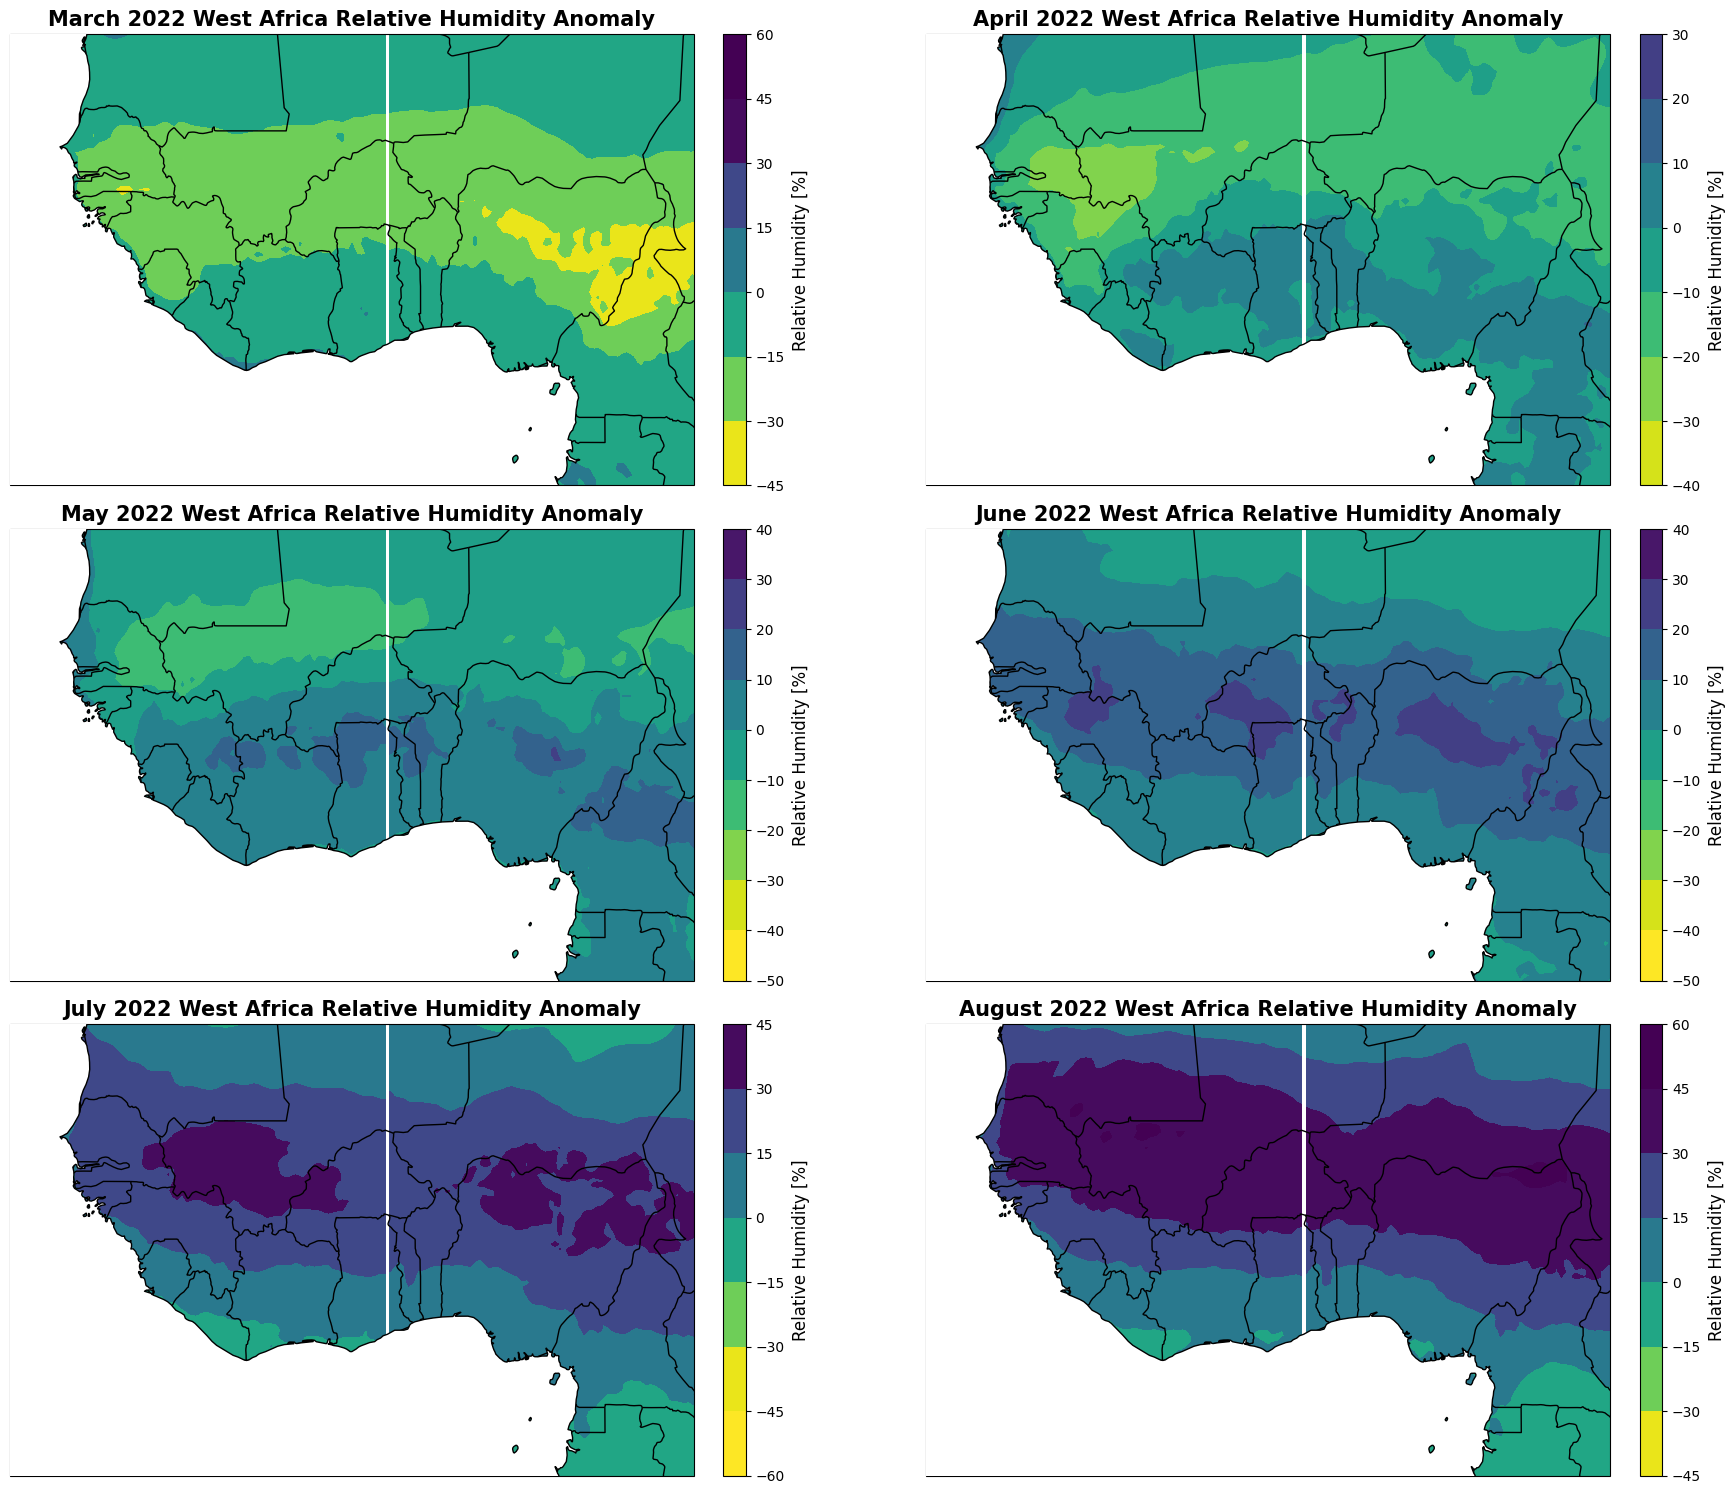

In [15]:
#define the function
def Global_plot(ERA5_dataset, title, ax):
    im = ax.contourf(ERA5_dataset.longitude, 
                       ERA5_dataset.latitude, 
                       ERA5_dataset,
                       transform=ccrs.PlateCarree(), 
                       vmin=-40, 
                       vmax= 40,
                       cmap='viridis_r') #, 
                       #shading='auto')

    ax.add_feature(cf.BORDERS)
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.OCEAN, edgecolor='black', zorder=100, facecolor='white')
    
    ax.set_extent([-20, 16, -1, 20], crs=ccrs.PlateCarree())  # Set extent for West Africa
    

    
    cb = plt.colorbar(im, ax=ax, fraction=0.0235, pad=0.03)
    cb.set_label(label = 'Relative Humidity [%]', fontsize=12, rotation=90, labelpad = 5)
    ax.set_title(title, fontweight='bold', fontsize = '15')
    

# Create a 3 by 2 subplot layout
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15),
                        subplot_kw=dict(projection=ccrs.Robinson(central_longitude = 0)))

# List of months
months = ['March', 'April', 'May', 'June', 'July', 'August']

# Iterate through each month and plot
for i, month in enumerate(months):
    row = i // 2
    col = i % 2
    
     #difference between the years
    #select the specific years needed
    t2m_1991_2020 =  era5_data['rh'].sel(time=slice('1991', '2020')) #base period
    
    # Let's start with the current month in 2023
    current_month = '2022-{:02d}'.format(i + 3)
    t2m_month_2023 = era5_data['rh'].sel(time=current_month)
    
    # Calculate averages
    t2m_month_2023_avg = t2m_month_2023.mean(dim='time')
    t2m_1991_2020_avg = t2m_1991_2020.mean(dim='time')
    
    # Calculate the mean difference
    t2m_diff_avg = t2m_month_2023_avg - t2m_1991_2020_avg
    
    # Plot on the corresponding subplot
    Global_plot(t2m_diff_avg, f'{month} 2022 West Africa Relative Humidity Anomaly', axs[row, col])

plt.tight_layout()
plt.show()

### Monthly 2023-2022 West Africa Relative Humidity Difference

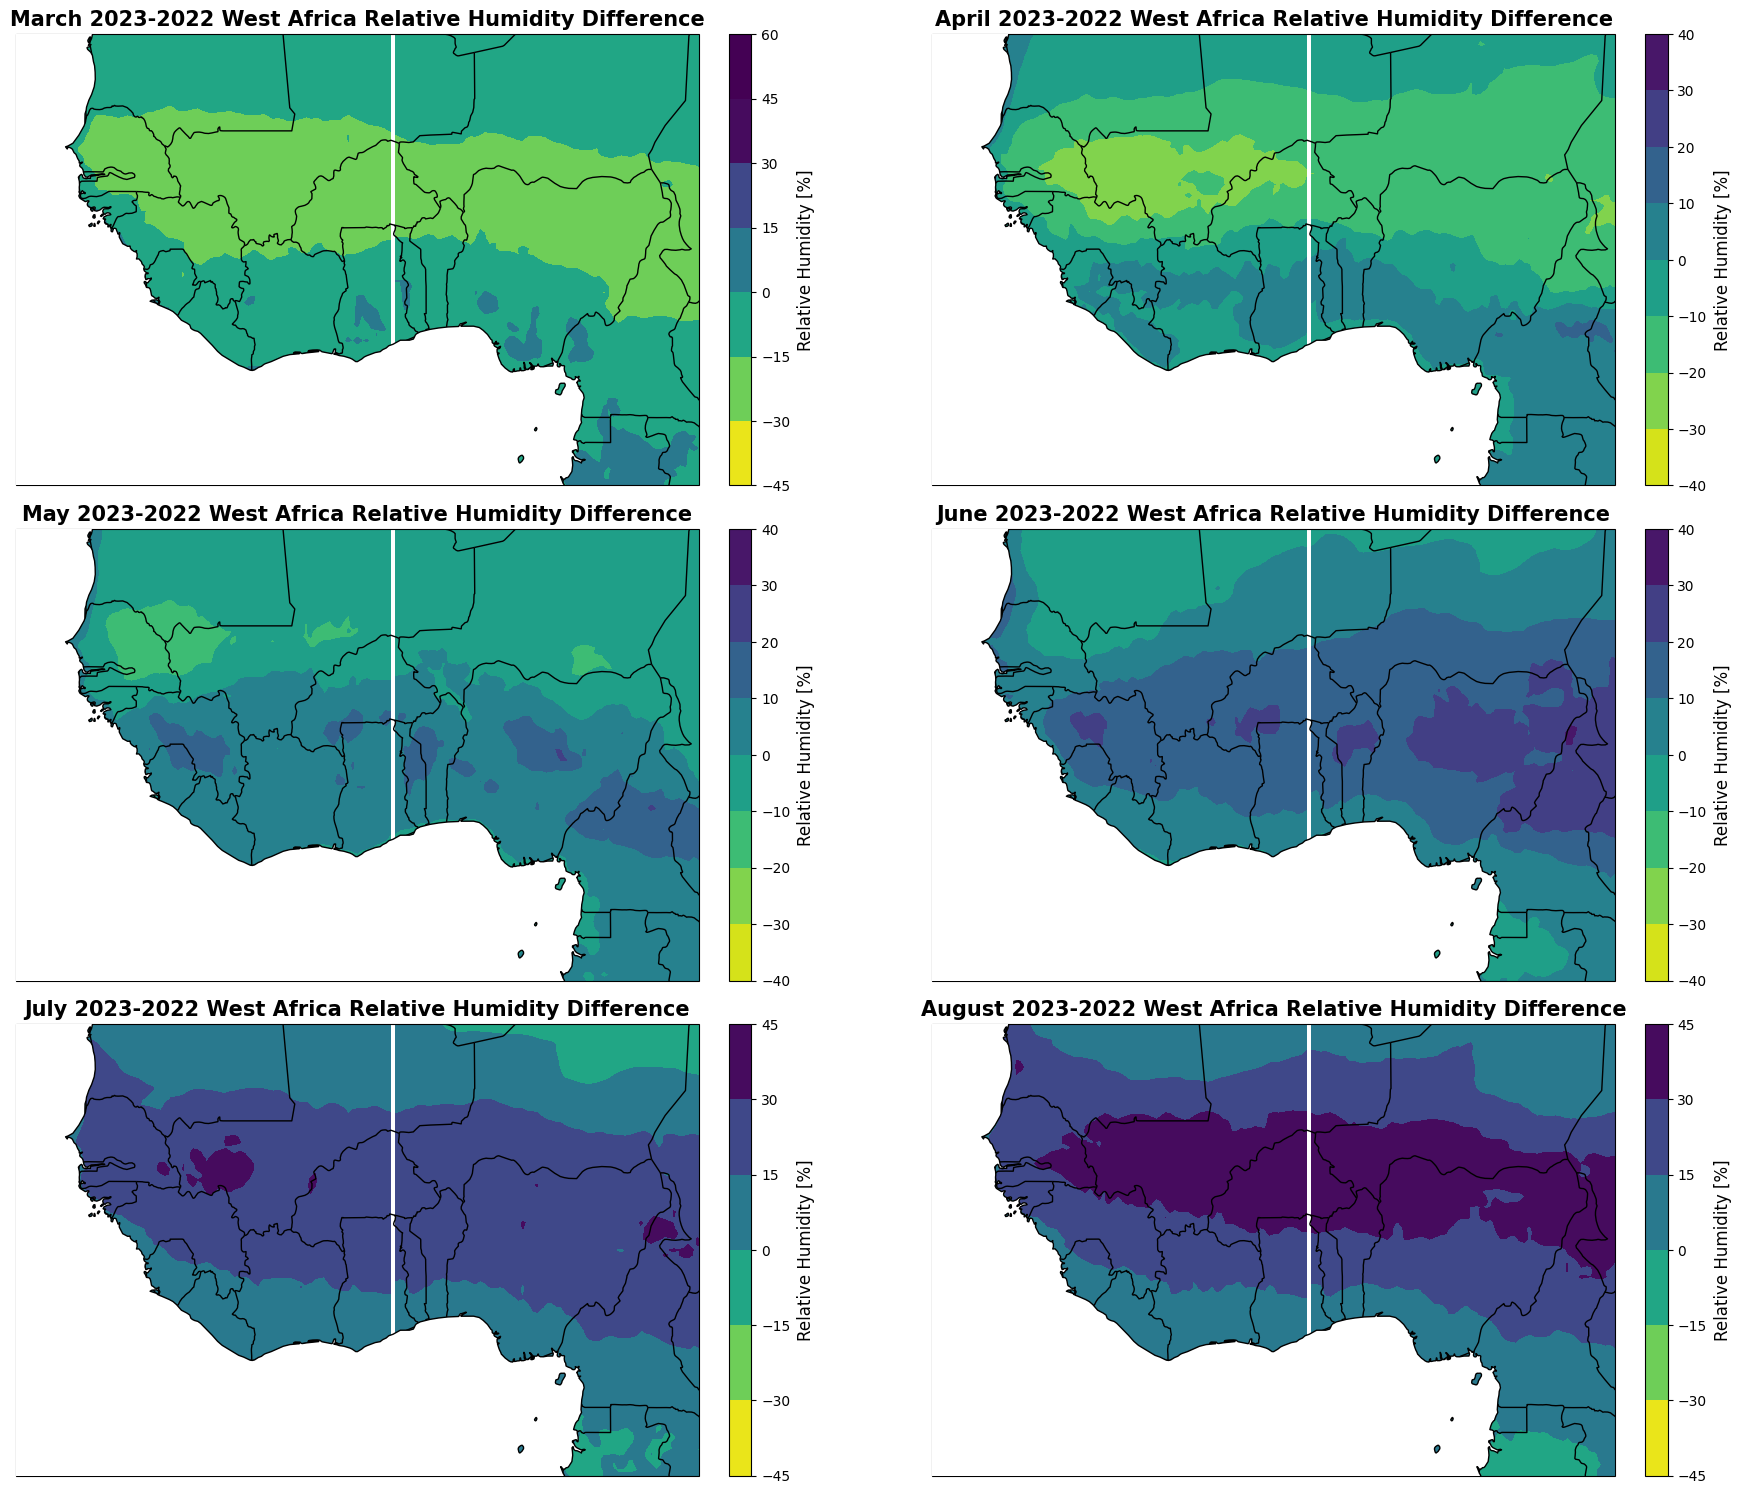

In [16]:
# define the function
def Global_plot(ERA5_dataset, title, ax):
    im = ax.contourf(ERA5_dataset.longitude, 
                       ERA5_dataset.latitude, 
                       ERA5_dataset,
                       transform=ccrs.PlateCarree(), 
                       cmap='viridis_r',
                       vmin=-40, 
                       vmax= 40) #, 
                       #shading='auto')

    ax.add_feature(cf.BORDERS)
    ax.coastlines(resolution='110m')
    ax.add_feature(cf.OCEAN, edgecolor='black', zorder=100, facecolor='white')
    
    ax.set_extent([-20, 16, -1, 20], crs=ccrs.PlateCarree())  # Set extent for West Africa
    
    
    cb = plt.colorbar(im, ax=ax, fraction=0.0235, pad=0.03)
    cb.set_label(label = 'Relative Humidity [%]', fontsize=12, rotation=90, labelpad = 5)

    ax.set_title(title, fontweight='bold', fontsize = '15')
    

# Create a 3 by 2 subplot layout
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15),
                        subplot_kw=dict(projection=ccrs.Robinson(central_longitude = 0)))

# List of months
months = ['March', 'April', 'May', 'June', 'July', 'August']

# Iterate through each month and plot
for i, month in enumerate(months):
    row = i // 2
    col = i % 2
    
     #difference between the years
    #select the specific years needed
    t2m_1991_2020 =  era5_data['rh'].sel(time='2022') #base period
    
    # Let's start with the current month in 2023
    current_month = '2023-{:02d}'.format(i + 3)
    t2m_month_2023 = era5_data['rh'].sel(time=current_month)
    
    # Calculate averages
    t2m_month_2023_avg = t2m_month_2023.mean(dim='time')
    t2m_1991_2020_avg = t2m_1991_2020.mean(dim='time')
    
    # Calculate the mean difference
    t2m_diff_avg = t2m_month_2023_avg - t2m_1991_2020_avg
    
    # Plot on the corresponding subplot
    Global_plot(t2m_diff_avg, f'{month} 2023-2022 West Africa Relative Humidity Difference', axs[row, col])

plt.tight_layout()
plt.show()

## Time Series Analysis

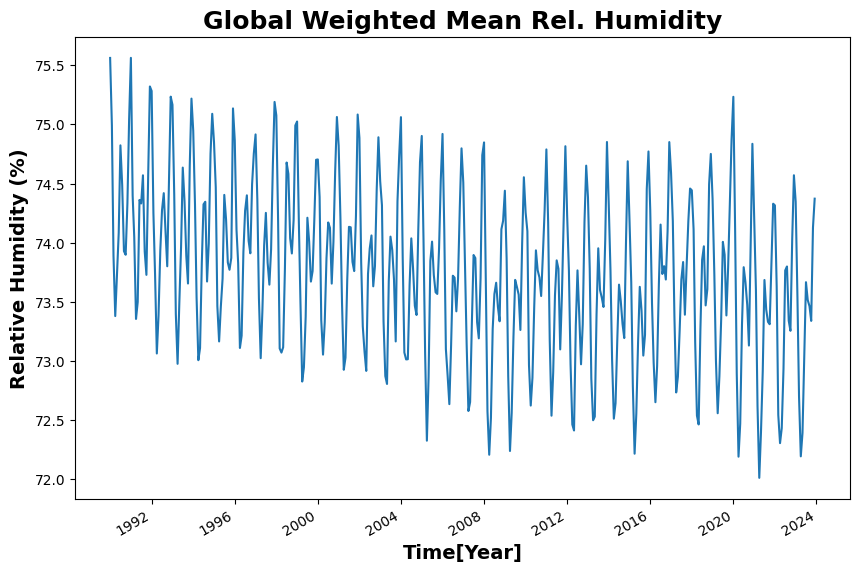

In [22]:
# Calculate weights
weights = np.cos(np.deg2rad(era5_data['rh'].latitude))
weights.name = "weights"

# Apply weights to the dataset
hum_weighted = era5_data['rh'].weighted(weights)

# Calculate the weighted mean
hum_mean = hum_weighted.mean(["longitude", "latitude"])

# Plot the mean using a line plot
plt.figure(figsize= (10,6))
hum_mean.plot()
plt.title('Global Weighted Mean Rel. Humidity', fontweight='bold', fontsize = '18')
plt.xlabel('Time[Year]', fontweight='bold', fontsize = '14')
plt.ylabel('Relative Humidity (%)', fontweight='bold', fontsize = '14')
plt.show()



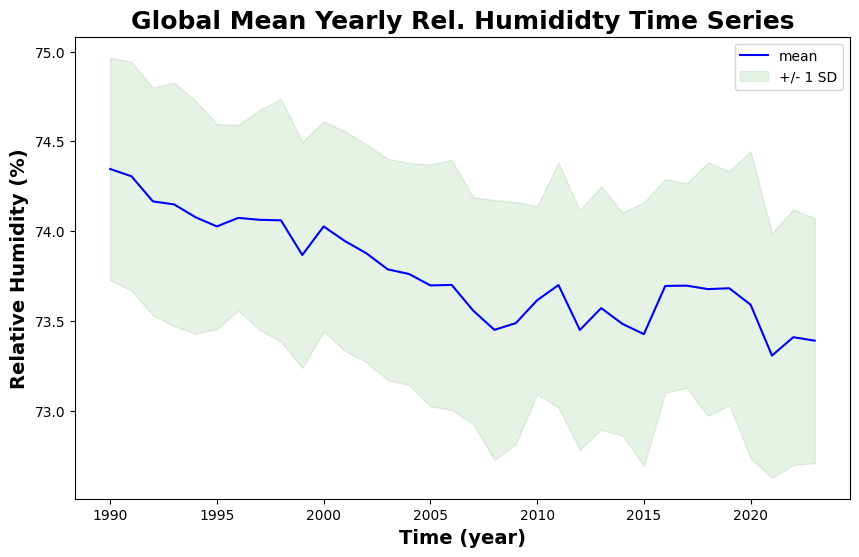

In [23]:

#calculate mean
hum_yearly = hum_mean.groupby('time.year').mean() 

#calculate standard deviation
std = hum_mean.groupby('time.year').std()

#plotting
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(hum_yearly.year, hum_yearly, color='blue', label='mean')

ax.fill_between(hum_yearly.year, (hum_yearly + std), (hum_yearly - std), alpha=0.1, color='green', label='+/- 1 SD')


plt.title('Global Mean Yearly Rel. Humididty Time Series', fontweight='bold', fontsize = '18')
plt.xlabel('Time (year)', fontweight='bold', fontsize = '14')
plt.ylabel('Relative Humidity (%)', fontweight='bold', fontsize = '14')
plt.legend()


Text(0, 0.5, 'Relative Humidity [%]')

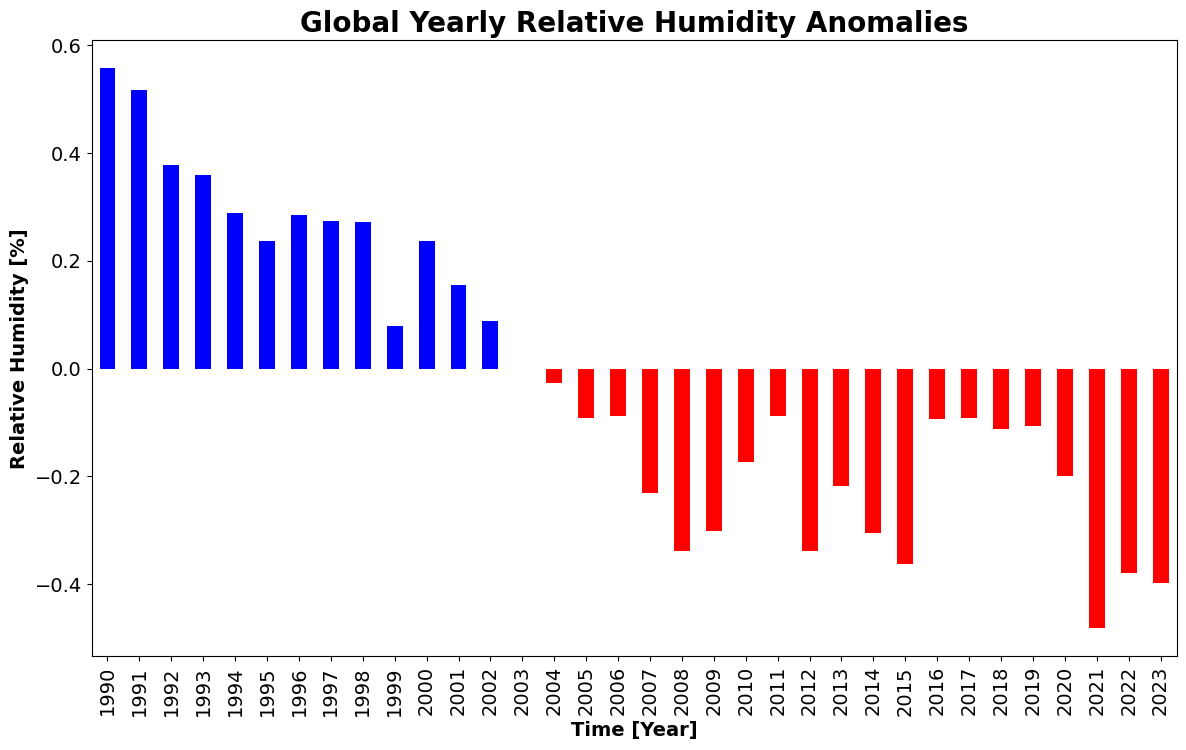

In [25]:
hum_subset = hum_yearly.where((hum_yearly.year > 1990) & (hum_yearly.year < 2021), drop=True)
hum_clim = hum_subset.mean()
hum_anom = hum_yearly - hum_clim

# # Provide a name for the DataArray
# hum_anom.name = 'Humidity_Anomaly'

df = hum_anom.to_dataframe()
df['positive'] = df['rh'] > 0 # Access the DataArray directly
df.head() # show only first five rows





plt.rcParams.update({'font.size': 20}) # must set in top
# Create the plot
ax = df['rh'].plot(
    figsize=(14, 8),
    kind='bar',
    color=df.positive.map({True: 'blue', False: 'red'}),
    fontsize=14
)

# Set the title 
ax.set_title('Global Yearly Relative Humidity Anomalies', fontweight='bold', fontsize='20')

# Set the x-label and y-label 
ax.set_xlabel('Time [Year]', fontweight='bold', fontsize=14)
ax.set_ylabel('Relative Humidity [%]', fontweight='bold', fontsize=14)

## West Africa Time Analysis

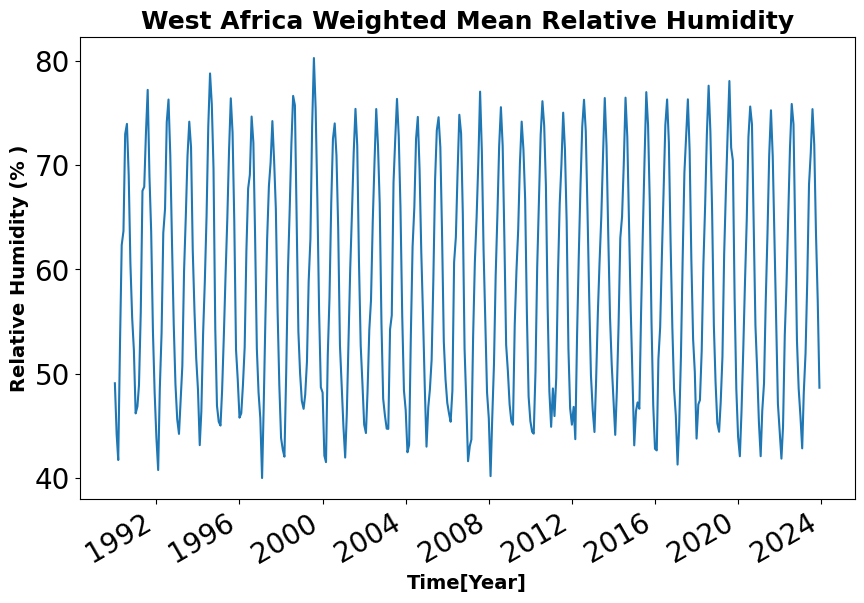

In [27]:
west_africa_hum = era5_data['rh'].sel(longitude = slice(-20, 16), latitude = slice(18, -1))

# Calculate weights
weights = np.cos(np.deg2rad(west_africa_hum.latitude))
weights.name = "weights"

# Apply weights to the dataset
hum_weighted = west_africa_hum.weighted(weights)

# Calculate the weighted mean
hum_mean1 = hum_weighted.mean(["longitude", "latitude"])

# Plot the mean using a line plot
plt.figure(figsize = (10,6))
hum_mean1.plot()
plt.title('West Africa Weighted Mean Relative Humidity', fontweight='bold', fontsize = '18')
plt.xlabel('Time[Year]', fontweight='bold', fontsize = '14')
plt.ylabel('Relative Humidity (% )', fontweight='bold', fontsize = '14')
plt.show()

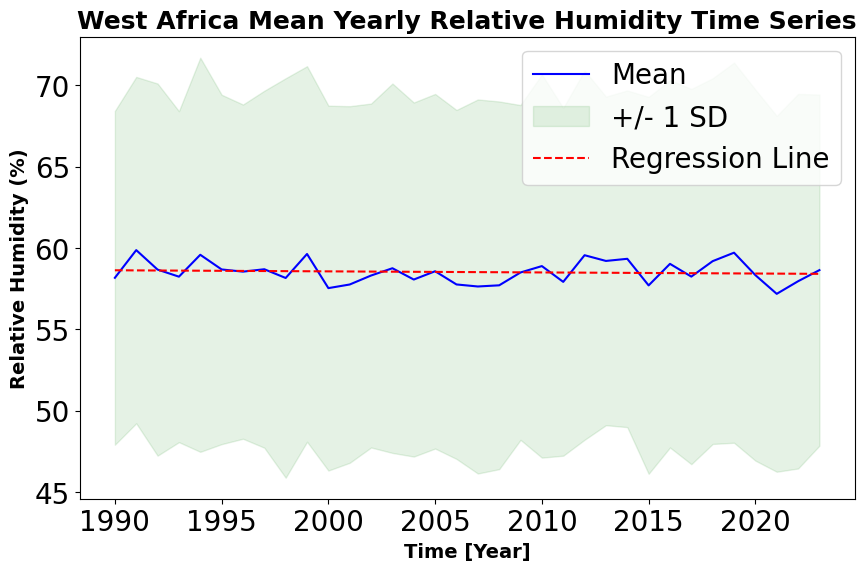

In [28]:

# Calculate mean
hum_yearly1 = hum_mean1.groupby('time.year').mean()

# Calculate standard deviation
std1 = hum_mean1.groupby('time.year').std()

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(hum_yearly1.year, hum_yearly1, color='blue', label='Mean')
ax.fill_between(hum_yearly1.year, (hum_yearly1 + std1), (hum_yearly1 - std1), alpha=0.1, color='green', label='+/- 1 SD')

# Prepare data for regression line
years = hum_yearly1.year.values
humidity_values = hum_yearly1.values
slope, intercept = np.polyfit(years, humidity_values, 1)
regression_line = slope * years + intercept

# Plot regression line
ax.plot(years, regression_line, color='red', linestyle='--', label='Regression Line')

plt.title('West Africa Mean Yearly Relative Humidity Time Series', fontweight='bold', fontsize = '18')
plt.xlabel('Time [Year]', fontweight='bold', fontsize = '14')
plt.ylabel('Relative Humidity (%)', fontweight='bold', fontsize = '14')
plt.legend()

plt.show()


In [29]:
hum_subset = hum_yearly1.where((hum_yearly1.year > 1990) & (hum_yearly1.year < 2021), drop=True)
hum_clim = hum_subset.mean()
hum_anom = hum_yearly1 - hum_clim

# # Provide a name for the DataArray
# hum_anom.name = 'Humidity_Anomaly'

df = hum_anom.to_dataframe()
df['positive'] = df['rh'] > 0 # Access the DataArray directly
df.head() # show only first five rows





rh  positive
year                    
1990 -0.424427     False
1991  1.276726      True
1992  0.080177      True
1993 -0.354038     False
1994  0.990574      True

Text(0, 0.5, 'Relative Humidity [%]')

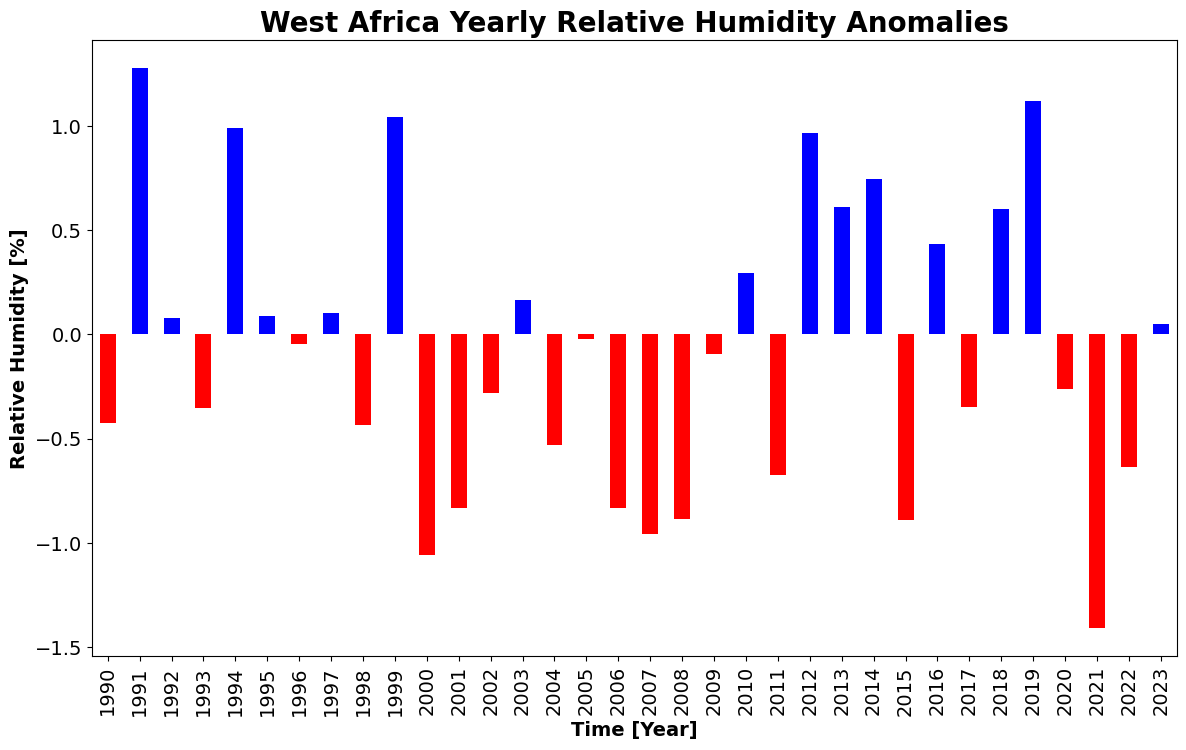

In [30]:


plt.rcParams.update({'font.size': 20}) # must set in top
# Create the plot
ax = df['rh'].plot(
    figsize=(14, 8),
    kind='bar',
    color=df.positive.map({True: 'blue', False: 'red'}),
    fontsize=14
)

# Set the title 
ax.set_title('West Africa Yearly Relative Humidity Anomalies', fontweight='bold', fontsize='20')

# Set the x-label and y-label 
ax.set_xlabel('Time [Year]', fontweight='bold', fontsize=14)
ax.set_ylabel('Relative Humidity [%]', fontweight='bold', fontsize=14)

### Time series comparing 2022 and 2023

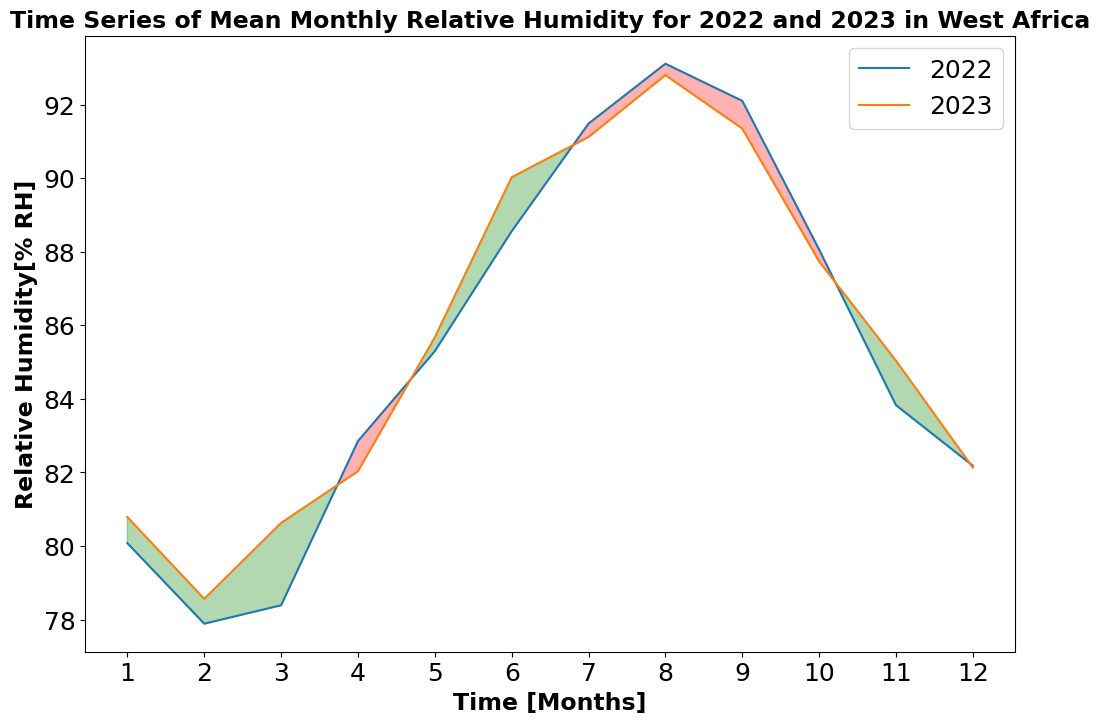

In [66]:
# Extracting data for West Africa
west_africa_hum = Rel_Humidity.sel(longitude=slice(-20, 16), latitude=slice(18, -1))


# Calculate weights for weighted mean
weights = np.cos(np.deg2rad(west_africa_hum.latitude))
weights.name = "weights"
west_africa_hum_weighted = west_africa_hum.weighted(weights)

# Calculate mean over the region
WestAfrica_hum = west_africa_hum_weighted.mean(["longitude", "latitude"])

# Select the years 2022 and 2023
WestAfrica_2022 = WestAfrica_hum.sel(time=slice('2022-01-01', '2022-12-31'))
WestAfrica_2023 = WestAfrica_hum.sel(time=slice('2023-01-01', '2023-12-31'))

# Group by month and calculate mean relative humidity for each month for both years
WestAfrica_2022_hum = WestAfrica_2022.groupby('time.month').mean()
WestAfrica_2023_hum = WestAfrica_2023.groupby('time.month').mean()

# Extracting humidity values correctly for both years
hum_2022 = WestAfrica_2022_hum.values  # Relative humidity for 2022
hum_2023 = WestAfrica_2023_hum.values  # Relative humidity for 2023

# Now, prepare to plot
months = np.arange(1, 13)  # Months from January to December

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(months, hum_2022, label='2022')  # Plot for 2022
ax.plot(months, hum_2023, label='2023')  # Plot for 2023
ax.set_title('Time Series of Mean Monthly Relative Humidity for 2022 and 2023 in West Africa', fontweight='bold', fontsize='15')
ax.set_ylabel('Relative Humidity[% RH]', fontweight='bold', fontsize='14')
ax.set_xlabel('Time [Months]', fontweight='bold', fontsize='14')
ax.set_xticks(months)  # Set x-ticks to show each month
# ax.grid(linestyle='--')

# Fill between plots with interpolation
ax.fill_between(months, hum_2022, hum_2023, where=(hum_2023 > hum_2022), color='green', alpha=0.3, interpolate=True)
ax.fill_between(months, hum_2022, hum_2023, where=(hum_2023 <= hum_2022), color='red', alpha=0.3, interpolate=True)

ax.legend()  # Add a legend to differentiate the years and conditions

plt.show()

## Global Rolling Mean Time Series

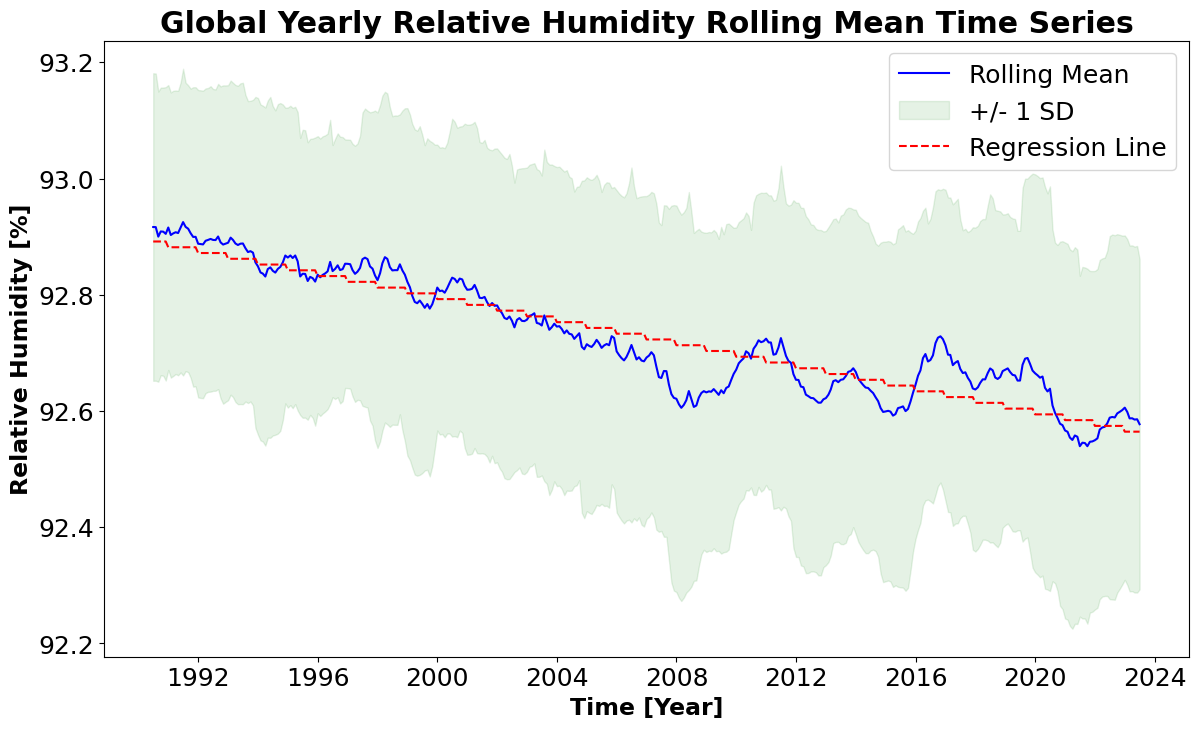

In [28]:
# Extracting data for West Africa
west_africa_hum = era5_data

# Calculate normalized weights
_, lat_field = np.meshgrid(west_africa_hum.longitude.values, west_africa_hum.latitude.values)
weight = np.cos(np.pi * lat_field / 180)
data = np.ma.masked_invalid(west_africa_hum.rh)
weight[data.mask[0, :, :]] = np.nan
weight_normalized = weight / np.nansum(weight)

# Add weights as second Xarray Data variable and apply weights to the tp
west_africa_hum['weight_normalized'] = xr.DataArray(
    weight_normalized, coords=[west_africa_hum.latitude.values, west_africa_hum.longitude.values], dims=['latitude', 'longitude'])
west_africa_hum['hum_norma'] = west_africa_hum.rh * west_africa_hum.weight_normalized

# Calculate the global values
west_africa_hum_m = west_africa_hum.hum_norma.sum(dim=['latitude', 'longitude'])
# Calculate the 12-month rolling mean and convert to mm
west_africa_hum_mean_rolling = west_africa_hum_m.rolling(time=12, center=True).mean().dropna('time')

# Calculate standard deviation and convert to mm
std_rr = west_africa_hum_m.rolling(time=12, center=True).std().dropna('time')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

ax.plot(west_africa_hum_mean_rolling.time, west_africa_hum_mean_rolling, color='blue', label='Rolling Mean')
ax.fill_between(west_africa_hum_mean_rolling.time, (west_africa_hum_mean_rolling + std_rr), (west_africa_hum_mean_rolling - std_rr), alpha=0.1, color='green', label='+/- 1 SD')

# Fit a linear regression model
# Convert times to a format suitable for regression analysis
time_encoded = np.array(west_africa_hum_mean_rolling.time.values, dtype='datetime64[Y]').astype(float)
slope, intercept = np.polyfit(time_encoded, west_africa_hum_mean_rolling.values, 1)
regression_line = slope * time_encoded + intercept

# Plot regression line
ax.plot(west_africa_hum_mean_rolling.time, regression_line, color='red', linestyle='--', label='Regression Line')

# Add title, x- and y-labels
plt.title('Global Yearly Relative Humidity Rolling Mean Time Series', fontweight='bold', fontsize = '20')
plt.ylabel("Relative Humidity [%]", fontsize=16, fontweight='bold')
plt.xlabel("Time [Year]", fontsize=16, fontweight='bold')
plt.legend()

plt.show()


## West Africa Rolling Mean Time Series

In [ ]:
# # Extracting data for West Africa
# west_africa_hum = Rel_Humidity.sel(longitude=slice(-20, 16), latitude=slice(18, -1))

# # Calculate normalized weights
# _, lat_field = np.meshgrid(west_africa_hum.longitude.values, west_africa_hum.latitude.values)
# weight = np.cos(np.pi * lat_field / 180)
# data = np.ma.masked_invalid(west_africa_hum)
# weight[data.mask[0, :, :]] = np.nan
# weight_normalized = weight / np.nansum(weight)

# # Add weights as second Xarray Data variable and apply weights to the tp
# west_africa_hum['weight_normalized'] = xr.DataArray(
#     weight_normalized, coords=[west_africa_hum.latitude.values, west_africa_hum.longitude.values], dims=['latitude', 'longitude'])
# west_africa_hum['hum_norma'] = west_africa_hum * west_africa_hum.weight_normalized

# # Calculate the global values
# west_africa_hum_m = west_africa_hum.hum_norma.sum(dim=['latitude', 'longitude'])
# # Calculate the 12-month rolling mean and convert to mm
# west_africa_hum_mean_rolling = west_africa_hum_m.rolling(time=12, center=True).mean().dropna('time')

# # Calculate standard deviation and convert to mm
# std_rr = west_africa_hum_m.rolling(time=12, center=True).std().dropna('time')

# # Plotting
# fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# ax.plot(west_africa_hum_mean_rolling.time, west_africa_hum_mean_rolling, color='blue', label='Rolling Mean')
# ax.fill_between(west_africa_hum_mean_rolling.time, (west_africa_hum_mean_rolling + std_rr), (west_africa_hum_mean_rolling - std_rr), alpha=0.1, color='green', label='+/- 1 SD')

# # Fit a linear regression model
# # Convert times to a format suitable for regression analysis
# time_encoded = np.array(west_africa_hum_mean_rolling.time.values, dtype='datetime64[Y]').astype(float)
# slope, intercept = np.polyfit(time_encoded, west_africa_hum_mean_rolling.values, 1)
# regression_line = slope * time_encoded + intercept

# # Plot regression line
# ax.plot(west_africa_hum_mean_rolling.time, regression_line, color='red', linestyle='--', label='Regression Line')

# # Add title, x- and y-labels
# plt.title('West Africa Yearly Relative Humidity Rolling Mean Time Series', fontweight='bold',fontsize = '20')
# plt.ylabel("Relative Humidity [%]", fontsize=16, fontweight='bold')
# plt.xlabel("Time [Year]", fontsize=16, fontweight='bold')
# plt.legend()

# plt.grid()

# plt.show()


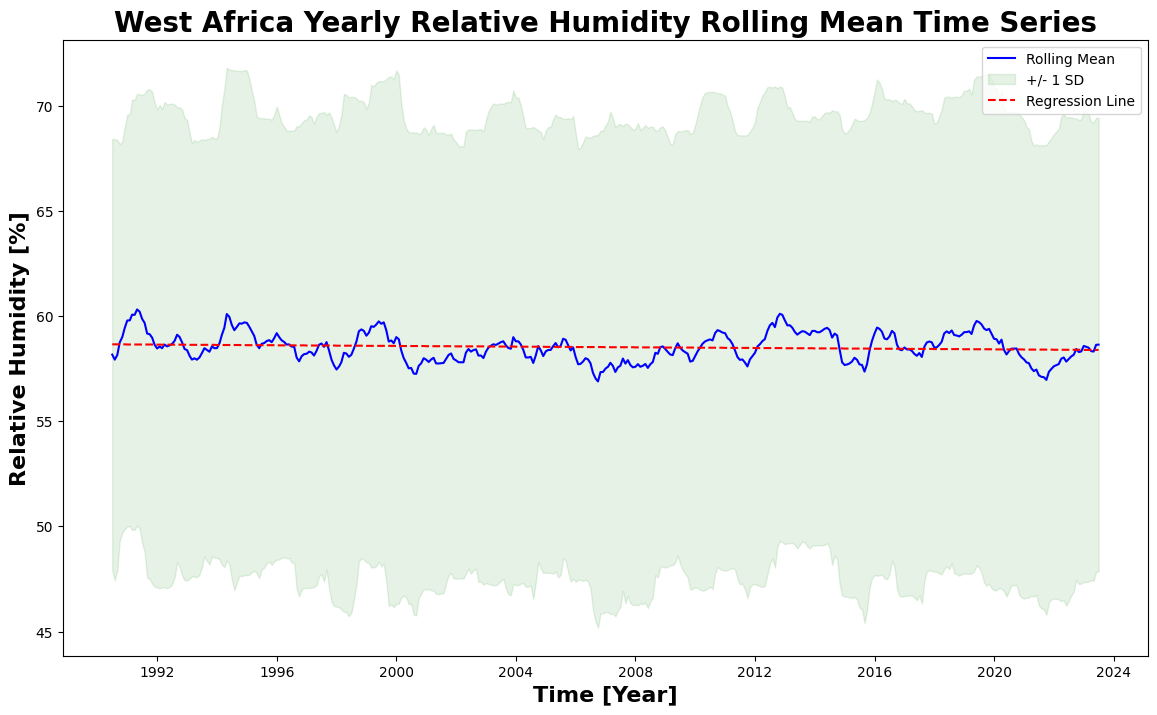

In [7]:
# Extracting data for West Africa
west_africa_hum = Rel_Humidity.sel(longitude=slice(-20, 16), latitude=slice(18, -1))

# Calculate normalized weights
_, lat_field = np.meshgrid(west_africa_hum.longitude.values, west_africa_hum.latitude.values)
weight = np.cos(np.pi * lat_field / 180)
data = np.ma.masked_invalid(west_africa_hum)
weight[data.mask[0, :, :]] = np.nan
weight_normalized = weight / np.nansum(weight)

# Add weights as second Xarray Data variable and apply weights to the tp
west_africa_hum['weight_normalized'] = xr.DataArray(
    weight_normalized, coords=[west_africa_hum.latitude.values, west_africa_hum.longitude.values], dims=['latitude', 'longitude'])
west_africa_hum['hum_norma'] = west_africa_hum * west_africa_hum.weight_normalized

# Calculate the global values
west_africa_hum_m = west_africa_hum.hum_norma.sum(dim=['latitude', 'longitude'])
# Calculate the 12-month rolling mean and convert to mm
west_africa_hum_mean_rolling = west_africa_hum_m.rolling(time=12, center=True).mean().dropna('time')

# Calculate standard deviation and convert to mm
std_rr = west_africa_hum_m.rolling(time=12, center=True).std().dropna('time')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

ax.plot(west_africa_hum_mean_rolling.time, west_africa_hum_mean_rolling, color='blue', label='Rolling Mean')
ax.fill_between(west_africa_hum_mean_rolling.time, (west_africa_hum_mean_rolling + std_rr), (west_africa_hum_mean_rolling - std_rr), alpha=0.1, color='green', label='+/- 1 SD')

# Fit a linear regression model
# Convert times to a format suitable for regression analysis
time_encoded = np.array(west_africa_hum_mean_rolling.time.values, dtype='datetime64[Y]').astype(float)
slope, intercept = np.polyfit(time_encoded, west_africa_hum_mean_rolling.values, 1)
regression_line = slope * time_encoded + intercept

# Plot regression line
ax.plot(west_africa_hum_mean_rolling.time, regression_line, color='red', linestyle='--', label='Regression Line')

# Add title, x- and y-labels
plt.title('West Africa Yearly Relative Humidity Rolling Mean Time Series', fontweight='bold',fontsize = '20')
plt.ylabel("Relative Humidity [%]", fontsize=16, fontweight='bold')
plt.xlabel("Time [Year]", fontsize=16, fontweight='bold')
plt.legend()

plt.show()


### Density Plot for 2022 and 2023

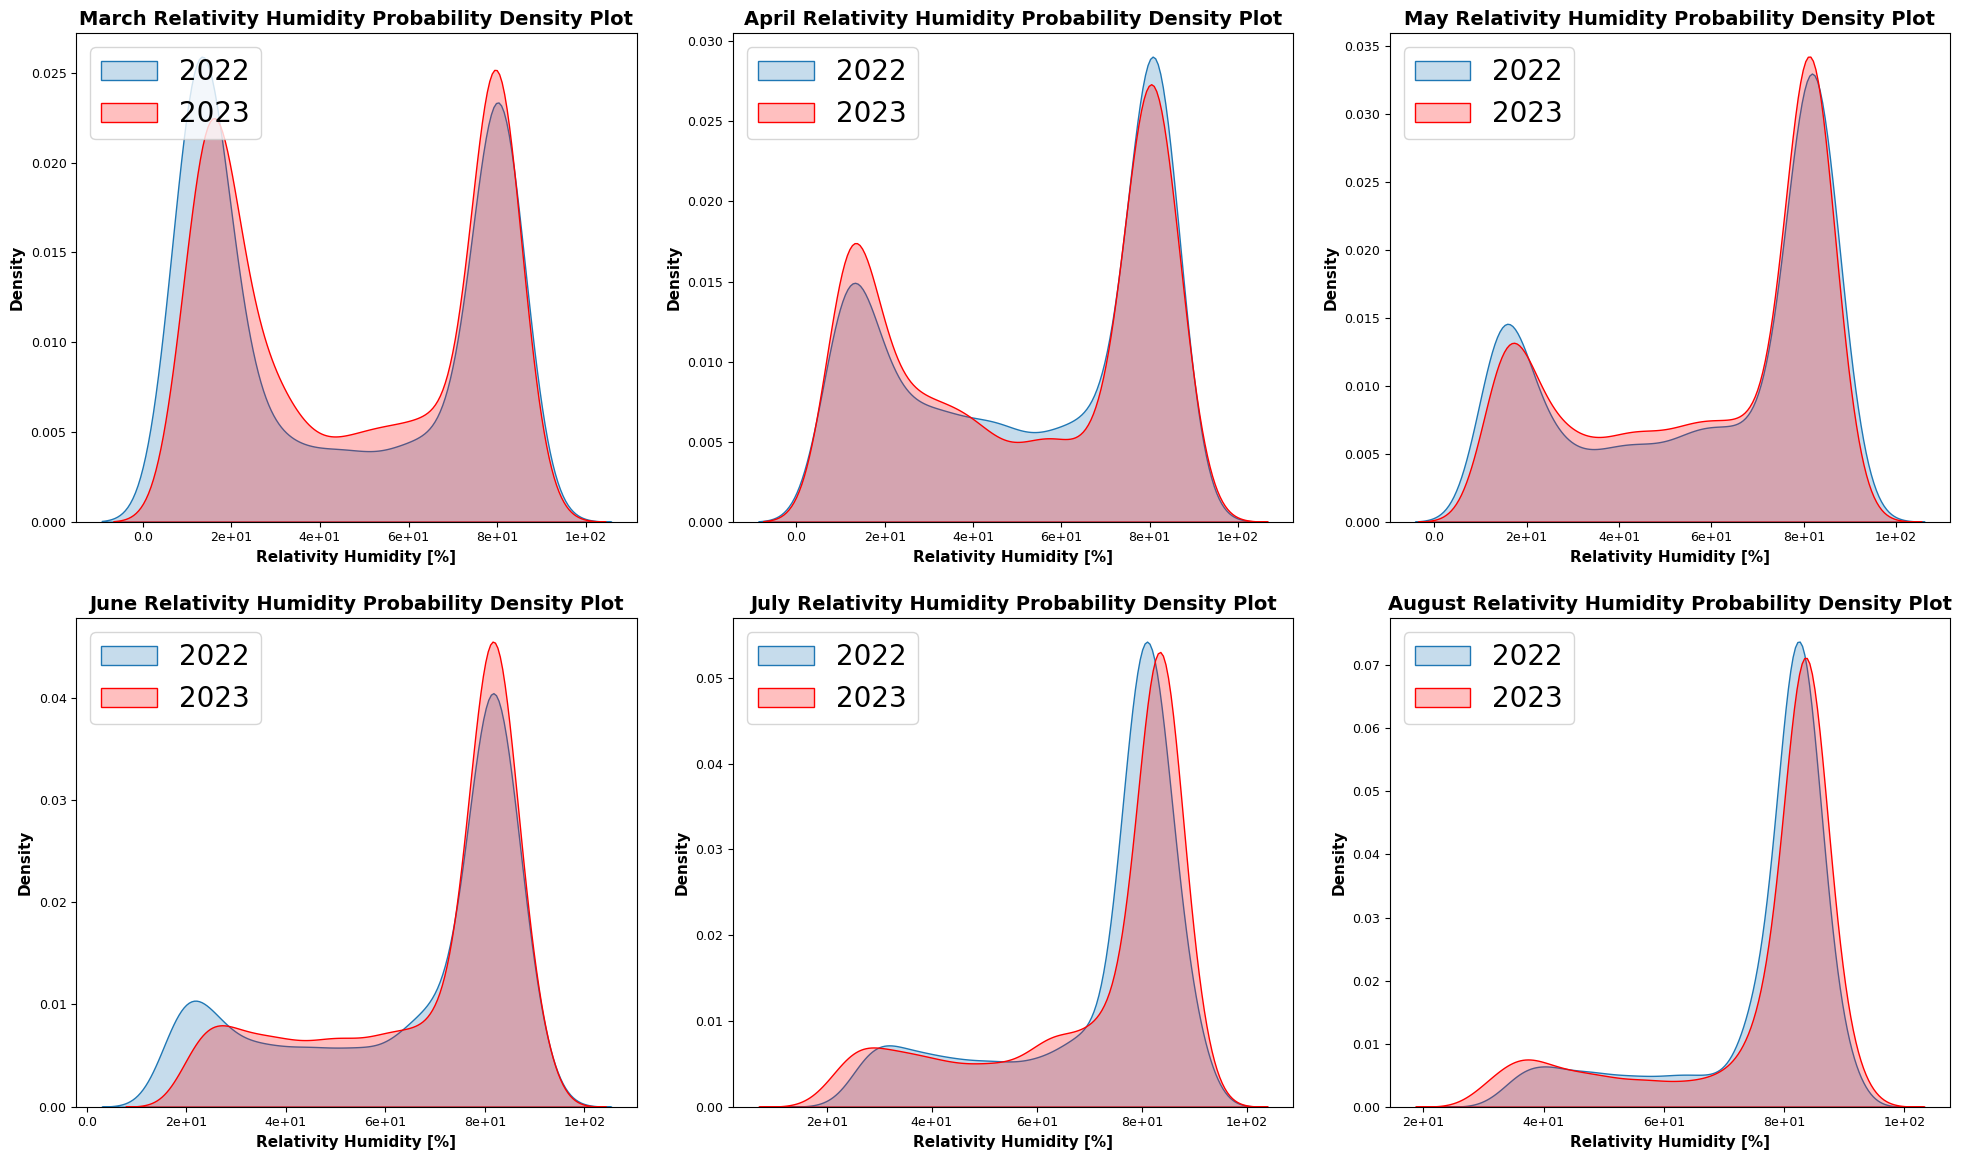

In [53]:
import matplotlib.ticker as ticker

# Select relevant geographic area
west_africa_hum = era5_data['rh'].sel(longitude=slice(-20, 16), latitude=slice(18, -1))

# Set up the plot - 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 12))  # Increased figure size
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Define colors for the two years
colors = ['#1f77b4', '#ff0000']  # Blue for 2022, Red for 2023

# Iterate over the selected months
for i, month in enumerate(range(3, 9)):
    # Determine the last day of the current month
    last_day = calendar.monthrange(2022, month)[1]
    
    # Select data for the current month and both years
    hum_2022 = west_africa_hum.sel(time=slice(f'2022-{month:02d}-01', f'2022-{month:02d}-{last_day}'))
    hum_2023 = west_africa_hum.sel(time=slice(f'2023-{month:02d}-01', f'2023-{month:02d}-{last_day}'))
    
    # Convert to pandas DataFrame for seaborn compatibility
    df_2022 = hum_2022.to_dataframe().reset_index()
    df_2023 = hum_2023.to_dataframe().reset_index()
    
    # Plot the density plots for both years on the same subplot
    sns.kdeplot(data=df_2022, x='rh', ax=axes[i], fill=True, color=colors[0], label='2022')
    sns.kdeplot(data=df_2023, x='rh', ax=axes[i], fill=True, color=colors[1], label='2023')
    
    # Setting the title for each subplot with month name
    month_name = calendar.month_name[month]
    axes[i].set_title(f'{month_name} Relativity Humidity Probability Density Plot', fontweight='bold', fontsize = '14')  # Adjust y for title position
    axes[i].legend(loc='upper left')
    
    # Set axis labels and make them bold
    axes[i].set_xlabel('Relativity Humidity [%]', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Density', fontsize=11, fontweight='bold')
    
     # Format the x-axis labels for better readability
    axes[i].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2}'))
    axes[i].tick_params(axis='x', labelsize=9)  # Adjust the x-axis tick label size
    axes[i].tick_params(axis='y', labelsize=9)  # Adjust the y-axis tick label size

# Adjust layout to prevent overlap
plt.tight_layout()


# Display the plot
plt.show()

# Suppress specific FutureWarnings from seaborn regarding use_inf_as_na
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated and will be removed in a future version.*")
